### Import State-Wise GDP at Current Price

This data has been saved as Data1.csv. We first import the pandas library and then read the csv file.<br> We then use the DataFrame.head() method to check out the first few rows of the dataframe. 

In [144]:
import pandas as pd
import numpy as np

df=pd.read_csv('Data1.csv')
df.head(3)

,Items Description,Duration,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chhattisgarh,Goa,Gujarat,Haryana,...,Telangana,Tripura,Uttar Pradesh,Uttarakhand,West Bengal1,Andaman & Nicobar Islands,Chandigarh,Delhi,Puducherry,All_India GDP
0,GSDP - CURRENT PRICES (` in Crore),2011-12,379402.0,11063.0,143175.0,247144.0,158074.0,42367.0,615606.0,297539.0,...,359433.0,19208.0,724049.0,115523.0,NaN,3979.0,18768.0,343767.0,16818.0,8736039.0
1,GSDP - CURRENT PRICES (` in Crore),2012-13,411404.0,12547.0,156864.0,282368.0,177511.0,38120.0,724495.0,347032.0,...,401493.0,21663.0,822903.0,131835.0,NaN,4421.0,21609.0,391238.0,18875.0,9946636.0
2,GSDP - CURRENT PRICES (` in Crore),2013-14,464272.0,14602.0,177745.0,317101.0,206690.0,35921.0,807623.0,400662.0,...,452186.0,25593.0,944146.0,149817.0,NaN,5159.0,24787.0,443783.0,21870.0,11236635.0


This is not a very friendly format. Eventually we would want, one row for each state, with yearly __GSDP__ and __Growth Rates__ appearing as columns. To do that we look at the first two columns carrying the items and the years.

We can merge them into one column. For example
>1.GSDP - CURRENT PRICES (` in Crore) and 2011-12 can be merged into GSDP_2012.<br>
>2.(% Growth over previous year) and 2012-13 can be merged into Growth_2012.<br>

To do this, we define a function merge_cols and apply them to the dataframe, so that we have a new column 'Metric'. Then we can drop the columns __'Items  Description','Duration','All_India GDP'__

We also need to drop the column for __West Bengal1__ as there is no data at all. Even the GSVA files also have no data for West Bengal

In [145]:
def merge_cols(row):
    
    if row['Items  Description'].find('GSDP')==0:
        y='GSDP_'+row['Duration'][0:4]
        return y
    else:
        y='Growth_'+row['Duration'][0:4]
        return y

df['Metric']= df.apply(merge_cols, axis=1)
df=df.drop(['Items  Description','Duration','All_India GDP','West Bengal1'],axis=1)

We now __transpose__ the dataframe, so that we can use the state-names are used as Index and the column 'Metric' becomes the header. This new dataframe is named __my_df__.

In [146]:
my_hdrs=list(df.Metric)
df.drop(['Metric'], axis=1,inplace=True)
my_df=df.T
my_df.columns=my_hdrs

We inspect the new data-frame my_df and shows a much more friendly format. We can use the state-names for merge operations coming up later.

In [147]:
my_df.head()

,GSDP_2011,GSDP_2012,GSDP_2013,GSDP_2014,GSDP_2015,GSDP_2016,Growth_2012,Growth_2013,Growth_2014,Growth_2015,Growth_2016
Andhra Pradesh,379402.0,411404.0,464272.0,526468.0,609934.0,699307.0,8.43,12.85,13.40,15.85,14.65
Arunachal Pradesh,11063.0,12547.0,14602.0,16761.0,18784.0,NaN,13.41,16.38,14.79,12.07,NaN
Assam,143175.0,156864.0,177745.0,198098.0,224234.0,NaN,9.56,13.31,11.45,13.19,NaN
Bihar,247144.0,282368.0,317101.0,373920.0,413503.0,NaN,14.25,12.30,17.92,10.59,NaN
Chhattisgarh,158074.0,177511.0,206690.0,234982.0,260776.0,290140.0,12.30,16.44,13.69,10.98,11.26


# Part 1

__Calculate the average growth of states over the duration 2013-14, 2014-15 and 2015-16 by taking the mean of the row '(% Growth over previous year)'. Compare the calculated value and plot it for the states.__

To do this, we take the row-wise mean from column __Growth_2013__ to __Growth_2015__ and put into a column __Avg_Growth__.

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

col=my_df.loc[:,'Growth_2013':'Growth_2015']
my_df['Avg_Growth']=col.mean(axis=1)


### Missing Data

We notice that many states do not have the GSDP value for 2015, as required to be plot. So we use the average growth calculated above to estimate the 2015 GSDP, wherever its missing.

In [149]:

def missing_gdp(row):
    if np.isnan(row['GSDP_2015']):
        return row['GSDP_2014']*(1+(row['Avg_Growth']/100))
    else:
        return row['GSDP_2015']

my_df['GSDP_2015']=my_df.apply(missing_gdp,axis=1)
my_df.sort_values(['GSDP_2015'], ascending=False,inplace=True)

Now that we have replaced the missing GSDP for 2015 with an estimate using the average growth rates, we can plot the Average Growth Rate and Total GDP state_wise

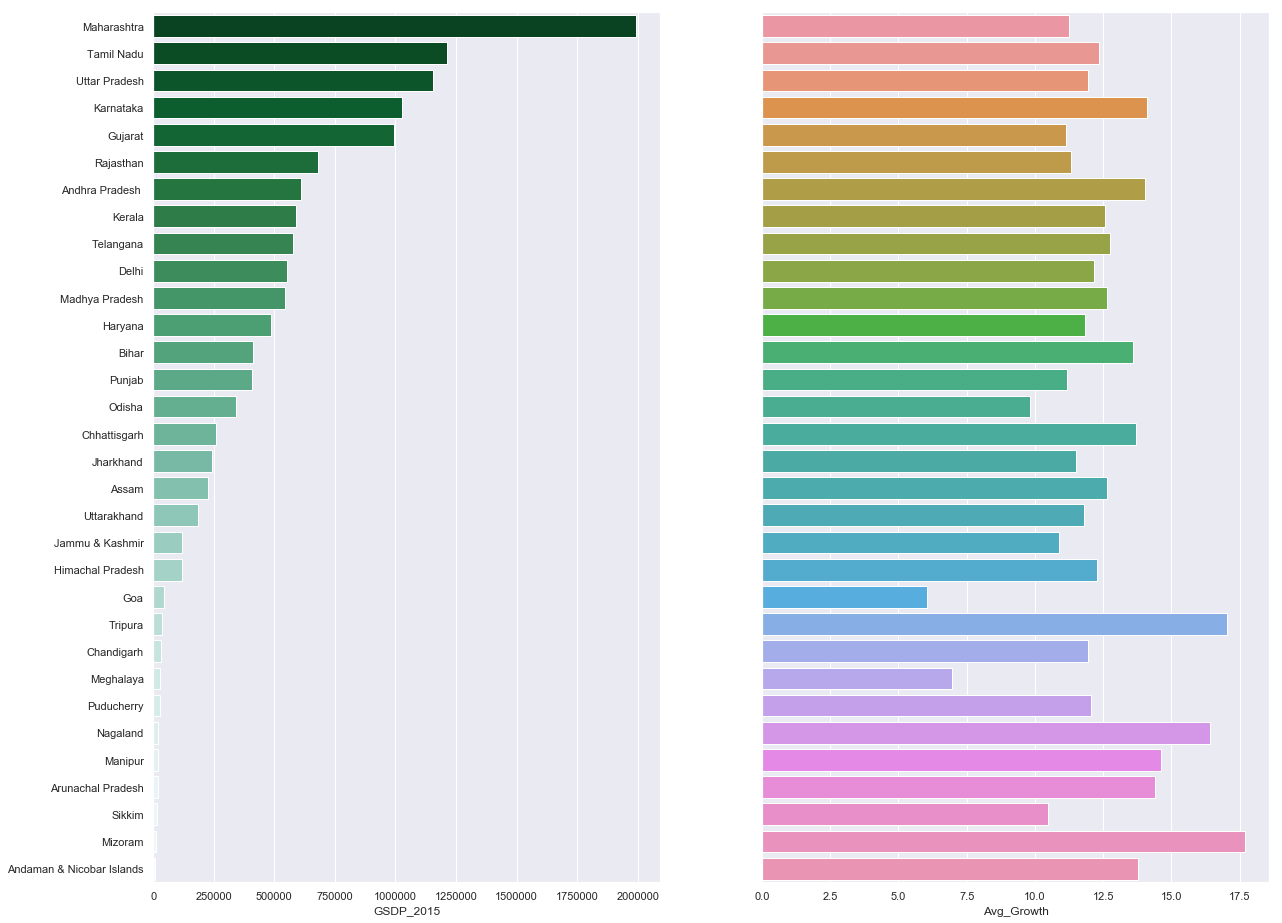

In [152]:
fig, ax = plt.subplots(1,2,figsize=(20, 16),sharey=True)

sns.set(style="darkgrid")
sns.barplot(x='Avg_Growth', y=my_df.index, data=my_df,orient='h',ax=ax[1])
sns.barplot(x='GSDP_2015', y=my_df.index, data=my_df,palette="BuGn_r",orient='h',ax=ax[0])

### Top and Bottom states in terms of GSDP

In [143]:
print('Top 5 States in terms of GSDP')
print(list(my_df.head(5).index))
print('Bottom 5 States in terms of GSDP')
print(list(my_df.tail(5).index))

Top 5 States in terms of GSDP
['Maharashtra', 'Tamil Nadu', 'Uttar Pradesh', 'Karnataka', 'Gujarat']
Bottom 5 States in terms of GSDP
['Manipur', 'Arunachal Pradesh', 'Sikkim', 'Mizoram', 'Andaman & Nicobar Islands']
